# IMPORTS AND HARDWARE

In [ ]:
# !pip install labelme tensorflow opencv-python matplotlib albumentations

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import json
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DATASET PREP

In [ ]:
#Pulling all image paths
images_links = tf.data.Dataset.list_files("/content/drive/MyDrive/cs231n_project/16_frame_imgs/*.jpg",shuffle = False)

In [ ]:
#Preparing Label Dictionary
with open('/content/drive/MyDrive/cs231n_project/16_fram_imgs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
images_array_mask1 = np.array(list(images_links.as_numpy_iterator()))#[:-3600]
# Create a boolean mask to filter out repeated images
mask = np.array([str(val)[-6] != ')' for val in images_array_mask1])
# Apply the mask to images array
images_array_mask1 = images_array_mask1[mask]

In [ ]:
labels_array = []
imagesFinal = []

#Creating image-label parallel arrays
for image in images_array_mask1:
  imagesFinal.append(image)
  #Isolating image ID
  s = str(image)
  last_slash_index = s.rfind('/')
  new_string = s[last_slash_index + 1:-1]

  labels_array.append(data[new_string])
images_array_mask2 = np.array(imagesFinal)

In [ ]:
numVids = int(images_array_mask2.shape[0]/16)
print("NUM VIDS", numVids)
images_array = images_array_mask2.reshape(numVids,16)
images_final = []
for frames in images_array:
  frame_numbers = [int(str(file_name)[int(str(file_name).rfind('frame'))+5:int(str(file_name).rfind('.'))]) for file_name in frames]

  # Sort the frame numbers and use the sorted indices to reorder the rows of the array
  sorted_indices = np.argsort(frame_numbers)
  images_final.append(frames[sorted_indices])

images_array = np.array(images_final).reshape(numVids*16,)
print(images_array)

NUM VIDS 825
[b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame0.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame1.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame2.jpg'
 ...
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame13.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame14.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame15.jpg']


## Dataset Preprocessing

In [ ]:
#Converts file path into image
def load_image(x):
    sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
    #reading in file name
    byte_img = tf.io.read_file(x)
    #converting to img array
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,sizeTup)
    img = img/255
    return img

In [ ]:
@tf.function
def preprocessData(x):
  sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
  x = tf.data.Dataset.from_tensor_slices(x)
  xProcessed = x.map(preprocess_sequence)
  return x

def preprocess_sequence(file_paths):
    print(file_paths)
    sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
    f#ile_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    images = file_paths.map(load_image)
    print(images)
    return images

def preprocess_images(x):
  sizeTup = (224,224)
  images = load_image(x)
  images = tf.image.resize(images,sizeTup)
  images = images/255
  return images


In [ ]:
spatialX = tf.data.Dataset.from_tensor_slices(images_array)
spatialX = spatialX.map(preprocess_images)
spatialX = spatialX.batch(16)
print(spatialX)
spatialY = np.array(labels_array).reshape(numVids,16)
spatialYList = spatialY[:, 0].flatten()
print(spatialYList.shape)
spatialY = tf.data.Dataset.from_tensor_slices(spatialYList)
print(spatialY)

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None)>
(825,)
<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
combined_dataset = tf.data.Dataset.zip((spatialX,spatialY))

#print("X",XData)
print("COMBINED",combined_dataset)

buffer_size = 1000  # Buffer size for shuffling
train_size = int(0.8 * len(combined_dataset))
val_size = test_size = int(0.1 * len(combined_dataset))

# Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(buffer_size)
train_dataset = combined_dataset.take(train_size).batch(16).prefetch(4)
remaining_dataset = combined_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).batch(16).prefetch(4)
test_dataset = remaining_dataset.skip(val_size).batch(16).prefetch(4)
print(combined_dataset)
print(train_dataset)
print(val_dataset)
print(test_dataset)

COMBINED <_ZipDataset element_spec=(TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# DATA VIZUALISER

[[[0.00294118 0.00260284 0.00243368]
  [0.00291097 0.00256055 0.00242764]
  [0.00302631 0.00265283 0.00256934]
  ...
  [0.00102433 0.00067062 0.00057835]
  [0.00102104 0.00066733 0.00057505]
  [0.0009727  0.00061899 0.00052672]]

 [[0.00298237 0.00263117 0.00246972]
  [0.002967   0.00260573 0.00247852]
  [0.00301246 0.00263695 0.0025553 ]
  ...
  [0.00101881 0.0006754  0.00057406]
  [0.00101405 0.00067064 0.0005715 ]
  [0.00096841 0.000625   0.00052586]]

 [[0.00307135 0.00269234 0.00254758]
  [0.00308801 0.00270331 0.00258841]
  [0.00298253 0.00260266 0.00252498]
  ...
  [0.0010069  0.00068573 0.00056479]
  [0.00099895 0.00067779 0.00056382]
  [0.00095914 0.00063798 0.00052401]]

 ...

 [[0.00056579 0.00067299 0.00089691]
  [0.00296634 0.00316203 0.00327343]
  [0.00370054 0.00387906 0.00388582]
  ...
  [0.00097084 0.0009548  0.00158101]
  [0.00094627 0.0008672  0.0014894 ]
  [0.00109618 0.00097528 0.00156633]]

 [[0.00071779 0.00083055 0.00107486]
  [0.00301784 0.00322056 0.00331156]


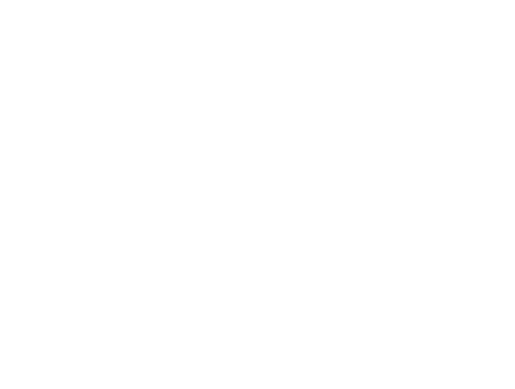

[[[0.00286813 0.00256055 0.00239139]
  [0.00290438 0.00256055 0.00242764]
  [0.00297605 0.002652   0.00249931]
  ...
  [0.0009933  0.00065057 0.00056599]
  [0.00095128 0.00062833 0.00060636]
  [0.00091503 0.00059208 0.00054594]]

 [[0.00292305 0.00260861 0.00243945]
  [0.00294851 0.0026167  0.00247839]
  [0.00296153 0.0026436  0.00249288]
  ...
  [0.00099189 0.00065272 0.00056213]
  [0.00095943 0.00062753 0.00059551]
  [0.00092791 0.00059465 0.00055195]]

 [[0.00304169 0.00271242 0.00254325]
  [0.00304384 0.00273799 0.00258803]
  [0.00293015 0.00262546 0.00247897]
  ...
  [0.00098884 0.00065735 0.00055379]
  [0.00097705 0.00062581 0.00057207]
  [0.00095571 0.00060022 0.00056493]]

 ...

 [[0.00056215 0.00069784 0.00091771]
  [0.00298792 0.0032004  0.00327789]
  [0.00370693 0.00390311 0.00388611]
  ...
  [0.00094584 0.00096727 0.00162307]
  [0.00097589 0.00091973 0.00157851]
  [0.00113988 0.00103387 0.0016437 ]]

 [[0.00069561 0.00083316 0.00109196]
  [0.00300778 0.00324396 0.00331522]


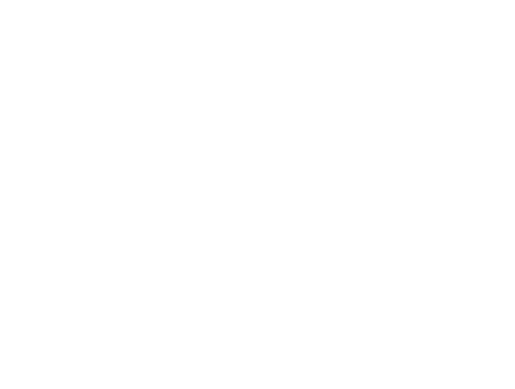

[[[0.00290273 0.00259516 0.00245675]
  [0.00288158 0.00257401 0.00247185]
  [0.00293761 0.00266958 0.0025081 ]
  ...
  [0.00099687 0.00069369 0.00061515]
  [0.00099357 0.00067062 0.00061844]
  [0.00099962 0.00067666 0.00063053]]

 [[0.00295336 0.00263721 0.00249708]
  [0.00293424 0.00262483 0.00251016]
  [0.00293454 0.00265769 0.00249952]
  ...
  [0.0010019  0.00068431 0.00060896]
  [0.00099566 0.00066308 0.00060747]
  [0.00100305 0.0006698  0.00062023]]

 [[0.00306273 0.00272804 0.00258421]
  [0.00304798 0.00273459 0.00259292]
  [0.00292792 0.002632   0.00248098]
  ...
  [0.00101275 0.00066405 0.00059558]
  [0.00100016 0.0006468  0.00058377]
  [0.00101046 0.00065497 0.00059798]]

 ...

 [[0.00051035 0.00063389 0.00089828]
  [0.00292392 0.00317763 0.00327372]
  [0.00367649 0.00389842 0.00389657]
  ...
  [0.00092889 0.00099402 0.00164674]
  [0.00091663 0.00093104 0.00155154]
  [0.00104984 0.00103933 0.00160999]]

 [[0.00063454 0.00081555 0.00109106]
  [0.0029986  0.00323113 0.00331503]


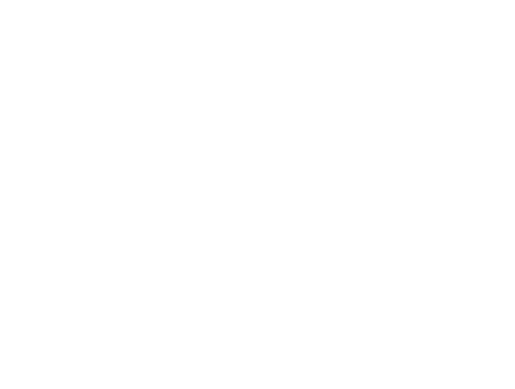

[[[0.00288735 0.00257978 0.00247213]
  [0.00287527 0.00255561 0.00247213]
  [0.0030351  0.00268248 0.00261548]
  ...
  [0.00103504 0.00064618 0.00063355]
  [0.00098231 0.00061982 0.00062037]
  [0.00096117 0.00062284 0.00065359]]

 [[0.00293541 0.00262526 0.0025116 ]
  [0.00291928 0.00260447 0.0025143 ]
  [0.00300518 0.00266164 0.00259329]
  ...
  [0.00102922 0.00064502 0.00061743]
  [0.00097723 0.00061976 0.00060424]
  [0.00096889 0.00062884 0.00064759]]

 [[0.00303922 0.00272351 0.00259687]
  [0.00301435 0.00270999 0.0026054 ]
  [0.00294057 0.00261663 0.00254536]
  ...
  [0.00101664 0.0006425  0.0005826 ]
  [0.00096624 0.00061962 0.00056942]
  [0.00098558 0.00064182 0.00063461]]

 ...

 [[0.00051193 0.00063499 0.00081778]
  [0.00292265 0.00317822 0.00325434]
  [0.00369612 0.00388752 0.00391129]
  ...
  [0.00097206 0.001004   0.00163737]
  [0.00094583 0.00095988 0.0015658 ]
  [0.00105169 0.00097418 0.00158627]]

 [[0.00063242 0.00078699 0.00102354]
  [0.00297905 0.00322099 0.00329989]


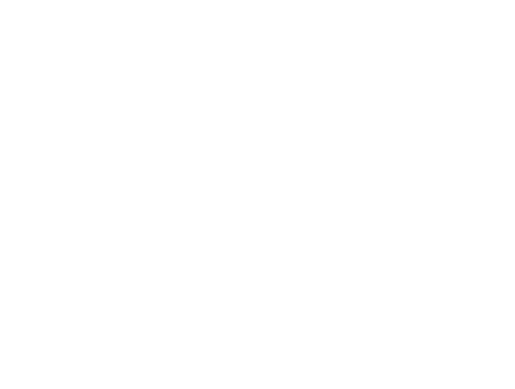

[[[0.00286813 0.00265283 0.00251442]
  [0.00284396 0.00258637 0.00246306]
  [0.00299555 0.00268688 0.00253556]
  ...
  [0.00097133 0.00067913 0.00055775]
  [0.00096968 0.0006709  0.00053963]
  [0.0009727  0.00064975 0.00057286]]

 [[0.00292048 0.00268458 0.00254617]
  [0.00289833 0.00263093 0.00250358]
  [0.00297269 0.00267149 0.00252055]
  ...
  [0.0009766  0.0006822  0.00055947]
  [0.00096705 0.00067194 0.00054594]
  [0.00095726 0.00065147 0.00056771]]

 [[0.00303355 0.00275316 0.00261476]
  [0.00301578 0.00272719 0.0025911 ]
  [0.0029233  0.00263826 0.00248811]
  ...
  [0.00098799 0.00068882 0.00056318]
  [0.00096135 0.00067419 0.00055958]
  [0.00092389 0.00065517 0.00055659]]

 ...

 [[0.00050946 0.00063798 0.00082438]
  [0.00293328 0.00318827 0.00325432]
  [0.00367094 0.00388017 0.00390889]
  ...
  [0.00092078 0.00098923 0.00161672]
  [0.00089723 0.00094445 0.00154913]
  [0.00104555 0.00101077 0.00162351]]

 [[0.00064477 0.00083261 0.00105979]
  [0.00296665 0.00323581 0.00329894]


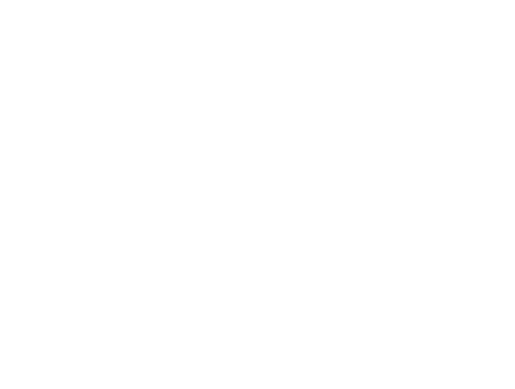

[[[0.00290657 0.00269127 0.00249135]
  [0.00284314 0.0025795  0.00244604]
  [0.00293953 0.00268248 0.002493  ]
  ...
  [0.00095046 0.00064838 0.00052095]
  [0.00089032 0.0006146  0.00050036]
  [0.00084198 0.00062668 0.00048827]]

 [[0.00294948 0.00270586 0.00252224]
  [0.00289346 0.00262578 0.00248907]
  [0.00291409 0.00266459 0.00247976]
  ...
  [0.00094703 0.00065144 0.00052291]
  [0.00089093 0.00062318 0.00049386]
  [0.00085743 0.00063526 0.00048312]]

 [[0.00304217 0.00273737 0.00258898]
  [0.00300217 0.00272575 0.00258202]
  [0.00285914 0.00262592 0.00245116]
  ...
  [0.00093961 0.00065806 0.00052715]
  [0.00089225 0.00064172 0.00047982]
  [0.0008908  0.0006538  0.000472  ]]

 ...

 [[0.00056544 0.00065905 0.00086111]
  [0.00284149 0.0031594  0.00324906]
  [0.00355194 0.00388505 0.00389509]
  ...
  [0.00085279 0.00089532 0.0014723 ]
  [0.00082184 0.00087077 0.00140902]
  [0.0009393  0.00094888 0.00142078]]

 [[0.00060993 0.00068686 0.00097418]
  [0.00284374 0.00318575 0.00328057]


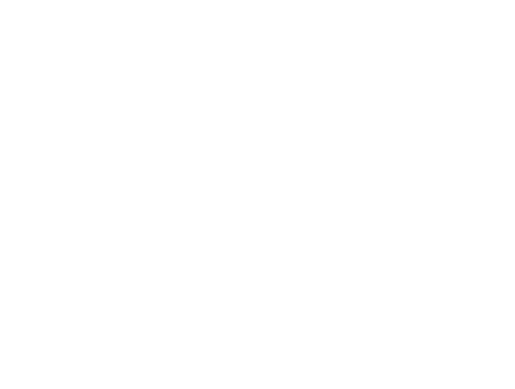

[[[0.00289504 0.00267974 0.00226451]
  [0.00287087 0.00263141 0.00224035]
  [0.00300763 0.00275169 0.00235734]
  ...
  [0.00092574 0.00061817 0.00047976]
  [0.00092657 0.00062558 0.00048388]
  [0.00088428 0.00060746 0.00045367]]

 [[0.00294052 0.00270977 0.00232373]
  [0.00291501 0.00268302 0.00229214]
  [0.0029841  0.00273526 0.00234036]
  ...
  [0.00093022 0.00062264 0.00048178]
  [0.00093012 0.00062914 0.00048057]
  [0.00089457 0.00061776 0.0004571 ]]

 [[0.00303877 0.00277465 0.00245163]
  [0.00301034 0.00279451 0.00240403]
  [0.00293325 0.00269978 0.00230368]
  ...
  [0.00093988 0.00063231 0.00048615]
  [0.0009378  0.00063682 0.00047342]
  [0.00091682 0.00064    0.00046452]]

 ...

 [[0.000541   0.00064776 0.00084998]
  [0.00283609 0.00316143 0.0032186 ]
  [0.00358823 0.00387807 0.00388727]
  ...
  [0.00083265 0.00093348 0.00142507]
  [0.00085974 0.00092917 0.00138907]
  [0.00108544 0.00107301 0.00147368]]

 [[0.00057066 0.00068854 0.00092598]
  [0.00284973 0.00319784 0.00324071]


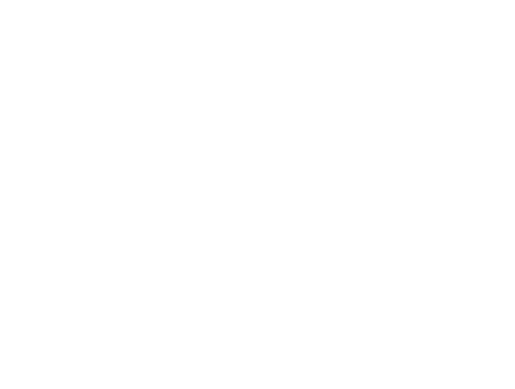

[[[0.00279508 0.00261053 0.00242599]
  [0.00286154 0.00262866 0.00243203]
  [0.00299335 0.00272752 0.00253749]
  ...
  [0.00093535 0.00062778 0.00050036]
  [0.00092052 0.00062284 0.00051519]
  [0.00088428 0.00062284 0.00051519]]

 [[0.0028603  0.00264829 0.00247405]
  [0.00289979 0.00266777 0.00247267]
  [0.00296577 0.002703   0.00251266]
  ...
  [0.00093824 0.00062576 0.0005014 ]
  [0.0009326  0.00062118 0.00052175]
  [0.00089972 0.00062455 0.00052377]]

 [[0.00300118 0.00272986 0.00257785]
  [0.00298241 0.00275224 0.00256046]
  [0.00290619 0.00265004 0.00245904]
  ...
  [0.00094446 0.00062139 0.00050365]
  [0.00095868 0.00061761 0.00053591]
  [0.00093309 0.00062826 0.00054231]]

 ...

 [[0.00059105 0.0007032  0.00093031]
  [0.00277456 0.00313336 0.00321453]
  [0.00354378 0.00387037 0.00387817]
  ...
  [0.00090074 0.0009463  0.0015741 ]
  [0.00088071 0.00091051 0.00151786]
  [0.00100078 0.00098252 0.00151497]]

 [[0.00068373 0.00077178 0.00104338]
  [0.00286142 0.00320923 0.00328391]


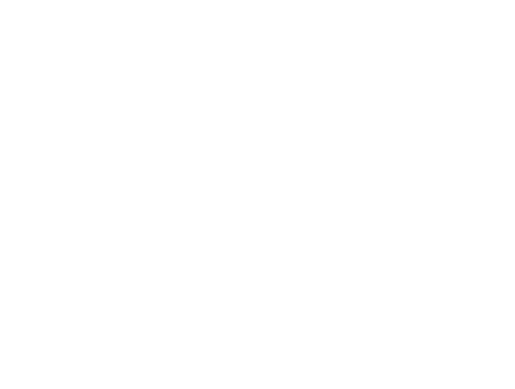

[[[0.0029258  0.00262207 0.00251442]
  [0.0028533  0.00261905 0.00248723]
  [0.00296946 0.00269484 0.00255643]
  ...
  [0.00097188 0.00060114 0.00054897]
  [0.00095705 0.00060609 0.00059345]
  [0.00098424 0.00061515 0.00058439]]

 [[0.00297986 0.00265811 0.00256591]
  [0.00290467 0.00265442 0.00252726]
  [0.00295886 0.00267872 0.00254534]
  ...
  [0.00097433 0.00061647 0.00054921]
  [0.00096392 0.000617   0.00059885]
  [0.0009911  0.00062201 0.00058439]]

 [[0.00309665 0.00273597 0.00267713]
  [0.00301562 0.00273082 0.00261372]
  [0.00293595 0.0026439  0.00252137]
  ...
  [0.00097963 0.00064957 0.00054974]
  [0.00097874 0.00064057 0.0006105 ]
  [0.00100593 0.00063684 0.00058439]]

 ...

 [[0.00059304 0.00068401 0.000876  ]
  [0.00293755 0.00316847 0.00326326]
  [0.00369177 0.00387279 0.00391404]
  ...
  [0.00094239 0.00098903 0.00163207]
  [0.00093851 0.00094658 0.00153961]
  [0.00107744 0.00101238 0.00162578]]

 [[0.00064494 0.00078411 0.00096313]
  [0.00298508 0.00320157 0.00327756]


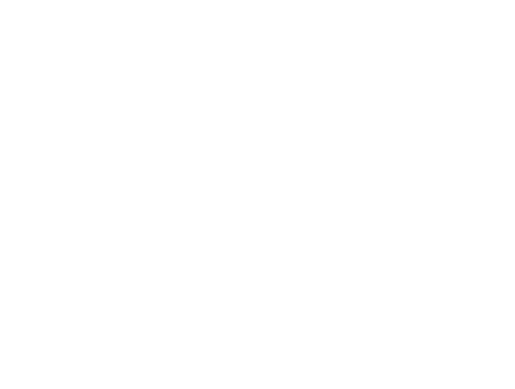

[[[0.00292964 0.00265283 0.00249904]
  [0.00291756 0.00261658 0.00249904]
  [0.0030329  0.00272533 0.00261767]
  ...
  [0.00097929 0.00065634 0.00059043]
  [0.00096941 0.00065305 0.00059702]
  [0.00091503 0.00062284 0.00053057]]

 [[0.00298199 0.00268801 0.00254109]
  [0.00296317 0.0026585  0.00253704]
  [0.00301377 0.0027062  0.0025961 ]
  ...
  [0.00098352 0.00066057 0.00059466]
  [0.00097548 0.00065764 0.00060383]
  [0.00093391 0.00063485 0.00055288]]

 [[0.00309507 0.00276401 0.00263192]
  [0.00306168 0.00274907 0.00261914]
  [0.00297246 0.00266489 0.00254949]
  ...
  [0.00099266 0.00066971 0.0006038 ]
  [0.00098858 0.00066757 0.00061852]
  [0.00097469 0.0006608  0.00060107]]

 ...

 [[0.00066249 0.00073495 0.00097064]
  [0.00298099 0.00321528 0.00328923]
  [0.00370184 0.0038862  0.00391371]
  ...
  [0.00091923 0.00095387 0.00157372]
  [0.00090806 0.00091278 0.00149566]
  [0.00111358 0.00102457 0.00163213]]

 [[0.00072736 0.00088695 0.00115601]
  [0.00298907 0.00326388 0.00332895]


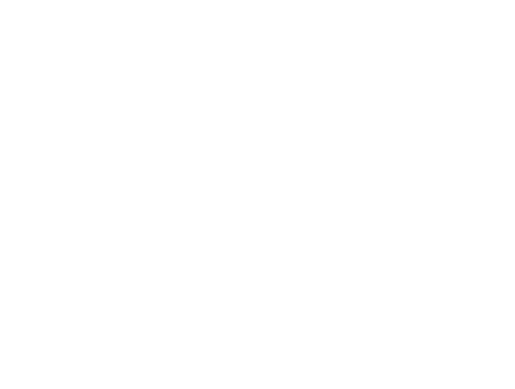

[[[0.00289888 0.00257978 0.00244521]
  [0.0028868  0.00260092 0.00248146]
  [0.00304169 0.0027451  0.0026347 ]
  ...
  [0.00097737 0.00062366 0.00050063]
  [0.00099138 0.00064508 0.00053029]
  [0.00096117 0.00064206 0.00055748]]

 [[0.00295467 0.00262612 0.00250185]
  [0.00294461 0.00264322 0.00252462]
  [0.00302005 0.00272174 0.00260411]
  ...
  [0.00098736 0.00063733 0.00051553]
  [0.00099236 0.00065618 0.00054077]
  [0.00095945 0.00064978 0.00054975]]

 [[0.00307516 0.00272622 0.0026242 ]
  [0.00306947 0.00273458 0.00261783]
  [0.00297331 0.0026713  0.00253804]
  ...
  [0.00100895 0.00066686 0.0005477 ]
  [0.00099448 0.00068014 0.00056341]
  [0.00095575 0.00066647 0.00053307]]

 ...

 [[0.00068507 0.00074525 0.00106419]
  [0.00299047 0.00321749 0.00330288]
  [0.00374932 0.00390306 0.00388521]
  ...
  [0.0009741  0.001005   0.00164398]
  [0.00092926 0.00094543 0.00155996]
  [0.00109371 0.00103676 0.00167895]]

 [[0.000724   0.00080086 0.00116985]
  [0.00301046 0.00324543 0.00332989]


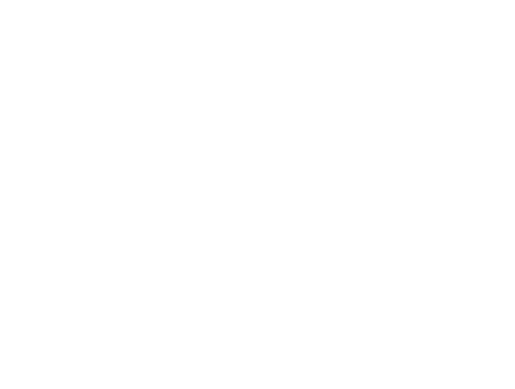

[[[0.00296424 0.00265667 0.00254902]
  [0.0029431  0.00263552 0.00252787]
  [0.00307821 0.00277064 0.00264321]
  ...
  [0.00102351 0.00063904 0.00057203]
  [0.00104575 0.00066128 0.00058769]
  [0.00104575 0.00066128 0.00059977]]

 [[0.00301316 0.00268842 0.00258764]
  [0.00300078 0.00268144 0.00257796]
  [0.00305443 0.00274318 0.00261698]
  ...
  [0.00103276 0.00064584 0.00057639]
  [0.00105666 0.0006668  0.00058707]
  [0.00105262 0.00066815 0.0006032 ]]

 [[0.00311882 0.00275701 0.00267105]
  [0.00312538 0.00278061 0.00268613]
  [0.00300305 0.00268386 0.00256031]
  ...
  [0.00105276 0.00066054 0.00058579]
  [0.00108023 0.00067872 0.00058575]
  [0.00106745 0.00068298 0.00061062]]

 ...

 [[0.00063554 0.00077038 0.00105674]
  [0.00297206 0.0032314  0.00330128]
  [0.00371539 0.00390912 0.00389728]
  ...
  [0.00099732 0.00100889 0.00166464]
  [0.000937   0.00096733 0.00153042]
  [0.00109594 0.00104692 0.00159928]]

 [[0.0006689  0.00084823 0.00117537]
  [0.00301271 0.00325828 0.00333107]


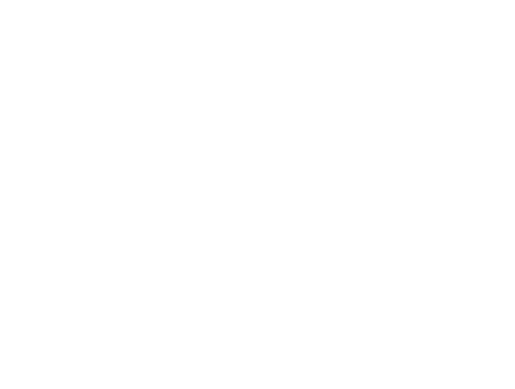

[[[0.00289504 0.00258747 0.00244906]
  [0.00294639 0.0025784  0.00249437]
  [0.00304196 0.00268715 0.0025438 ]
  ...
  [0.00104053 0.00068133 0.00060828]
  [0.00103559 0.0006665  0.00063465]
  [0.00102653 0.00065744 0.00064975]]

 [[0.0029534  0.00264325 0.00251685]
  [0.00299733 0.00263419 0.00254868]
  [0.00302909 0.00268115 0.00254699]
  ...
  [0.00104041 0.00068201 0.00060626]
  [0.00102609 0.00066846 0.00062324]
  [0.0010231  0.00065401 0.0006343 ]]

 [[0.00307945 0.00276374 0.0026633 ]
  [0.00310736 0.00275468 0.00266599]
  [0.00300128 0.00266817 0.00255387]
  ...
  [0.00104015 0.00068346 0.00060189]
  [0.00100557 0.0006727  0.00059862]
  [0.00101568 0.00064659 0.00060094]]

 ...

 [[0.00067701 0.00072816 0.00098105]
  [0.00308058 0.00321596 0.00327155]
  [0.00380418 0.00389851 0.00387417]
  ...
  [0.00098902 0.00103932 0.00170632]
  [0.0009754  0.00098242 0.00160867]
  [0.00114825 0.00105279 0.00169481]]

 [[0.00078452 0.00086903 0.00116456]
  [0.0030876  0.00326071 0.00330796]


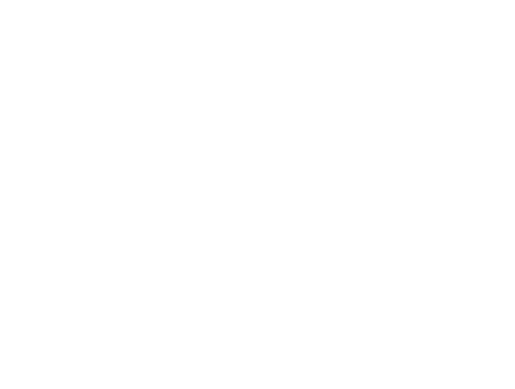

[[[0.00287197 0.00257978 0.00247213]
  [0.00293239 0.00257978 0.00250838]
  [0.00307739 0.0027083  0.00264678]
  ...
  [0.00107761 0.00069863 0.00063822]
  [0.00103971 0.00067062 0.00063986]
  [0.00104575 0.00067666 0.00064591]]

 [[0.00292261 0.00263041 0.00252276]
  [0.0029837  0.00263378 0.00255699]
  [0.0030533  0.00269205 0.00262588]
  ...
  [0.00107798 0.00069777 0.00063491]
  [0.00104927 0.00067675 0.00063913]
  [0.00105262 0.0006801  0.00064247]]

 [[0.00303197 0.00273978 0.00263213]
  [0.00309452 0.00275043 0.00266198]
  [0.00300126 0.00265697 0.00258073]
  ...
  [0.00107877 0.00069592 0.00062776]
  [0.00106993 0.00068999 0.00063754]
  [0.00106745 0.00068751 0.00063506]]

 ...

 [[0.00065435 0.00073382 0.00099691]
  [0.00302868 0.00321628 0.00327266]
  [0.00379061 0.00388676 0.00390362]
  ...
  [0.00100277 0.00101677 0.00169545]
  [0.00097896 0.00095903 0.0016181 ]
  [0.00114475 0.00105704 0.00172045]]

 [[0.00072479 0.00088397 0.00120637]
  [0.00307436 0.00326156 0.00333065]


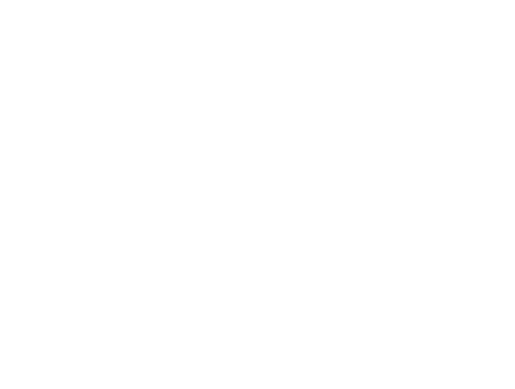

[[[0.00289888 0.00257593 0.00249904]
  [0.00285055 0.0025276  0.00247487]
  [0.00297825 0.00260587 0.0025795 ]
  ...
  [0.00103477 0.00066019 0.0006157 ]
  [0.00101335 0.00062888 0.00055803]
  [0.0010073  0.00062284 0.00054594]]

 [[0.00295209 0.00261884 0.00253852]
  [0.00291927 0.00258534 0.00252783]
  [0.00298003 0.00260807 0.00257766]
  ...
  [0.00103231 0.00066294 0.00061447]
  [0.0010074  0.00063752 0.00055551]
  [0.00100473 0.00063485 0.0005468 ]]

 [[0.00306702 0.00271153 0.00262378]
  [0.0030677  0.00271007 0.00264223]
  [0.00298387 0.00261284 0.00257369]
  ...
  [0.00102702 0.0006689  0.00061182]
  [0.00099456 0.00065619 0.00055009]
  [0.00099917 0.0006608  0.00054866]]

 ...

 [[0.00060876 0.00067385 0.00090597]
  [0.00299243 0.00322137 0.00327111]
  [0.00374719 0.0038984  0.0038676 ]
  ...
  [0.00096779 0.00094219 0.00160832]
  [0.00097731 0.00088655 0.00155972]
  [0.00118601 0.00100085 0.00168012]]

 [[0.00076818 0.00078878 0.00109875]
  [0.00304844 0.00324891 0.00331533]


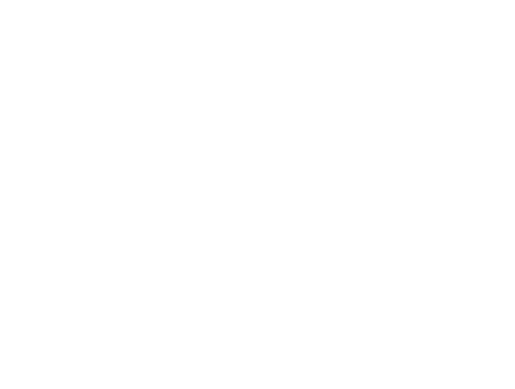

[[[0.00290657 0.00261438 0.00239908]
  [0.00289147 0.00259323 0.00239606]
  [0.00295408 0.00265914 0.00244219]
  ...
  [0.00099138 0.00067392 0.00058604]
  [0.0009782  0.00067062 0.00056297]
  [0.00098424 0.00067666 0.00056901]]

 [[0.00296321 0.00265729 0.00246258]
  [0.00294946 0.00264423 0.00245552]
  [0.00295065 0.00265608 0.00244317]
  ...
  [0.00099855 0.00067447 0.0005888 ]
  [0.00098206 0.00067448 0.00056683]
  [0.00097394 0.00066636 0.00055871]]

 [[0.00308556 0.00274997 0.00259976]
  [0.00307472 0.0027544  0.00258395]
  [0.00294324 0.00264946 0.00244529]
  ...
  [0.00101404 0.00067566 0.00059475]
  [0.0009904  0.00068282 0.00057517]
  [0.00095169 0.00064412 0.00053647]]

 ...

 [[0.00064127 0.000687   0.00092544]
  [0.00303689 0.00320339 0.003268  ]
  [0.00376743 0.00389215 0.00386749]
  ...
  [0.00093236 0.00097497 0.00159084]
  [0.00088356 0.00093024 0.00148508]
  [0.001091   0.00105622 0.00162128]]

 [[0.00074693 0.00082973 0.00113119]
  [0.00307846 0.00323252 0.00331791]


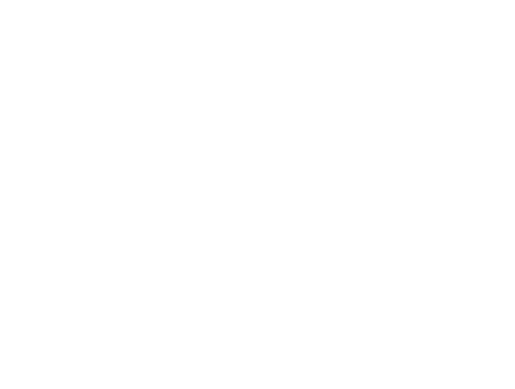

IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
#Vizualzing
image_generator = spatialX.as_numpy_iterator()
batch = image_generator.next()
count = 0
while count < 17:
  image = batch[count]
  print(image)
  #plt.imshow(image)
  plt.axis("off")
  plt.show()
  count+=1
  #image = preprocess_images(image)
#   image = image_generator.next()
#   plt.imshow(image)
#   plt.axis("off")
#   plt.show()
#   count+=1

In [ ]:
print(image.shape)

()


#MODEL ResNet50 3D

## Building Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input,Dense, GlobalAveragePooling2D, Conv3D

from tensorflow.keras.models import Model
import tensorflow_hub as hub


def build_3d_model():

  I3D_URL = "https://tfhub.dev/deepmind/i3d-kinetics-400/1"
  input_shape = (16, 224,224,3)
  input_layer = Input(shape=input_shape)

  # Load the I3D model from TensorFlow Hub
  base_model = hub.KerasLayer(I3D_URL, trainable=False, input_shape=(16, 224,224, 3))


  x = base_model(input_layer)
  layer1 = Dense(1024, activation='relu')(x)
  layer2 = Dense(512,activation='relu')(layer1)
  layer3 = Dense(512,activation='relu')(layer2)
  layer4 = Dense(256,activation='relu')(layer3)
  layer5 = Dense(128,activation='relu')(layer4)
  output = Dense(1, activation='sigmoid')(layer5)

  # Create the final model
  model_res = Model(inputs=input_layer, outputs=[output])

  # Freeze the pre-trained layers (optional)



  return model_res


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss(alpha=0.5):
    def loss(y_true, y_pred):
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        pr_loss = 1 - f1_score

        return alpha * bce_loss + (1 - alpha) * pr_loss

    return loss


In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = spatialYList  # Replace with your actual labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

NameError: name 'spatialYList' is not defined

In [4]:
model_res = build_3d_model()
model_res.compile(optimizer='adam', loss=custom_loss(0.5), metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 keras_layer (KerasLayer)    (None, 400)               12704544  
                                                                 
 dense (Dense)               (None, 1024)              410624    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                             

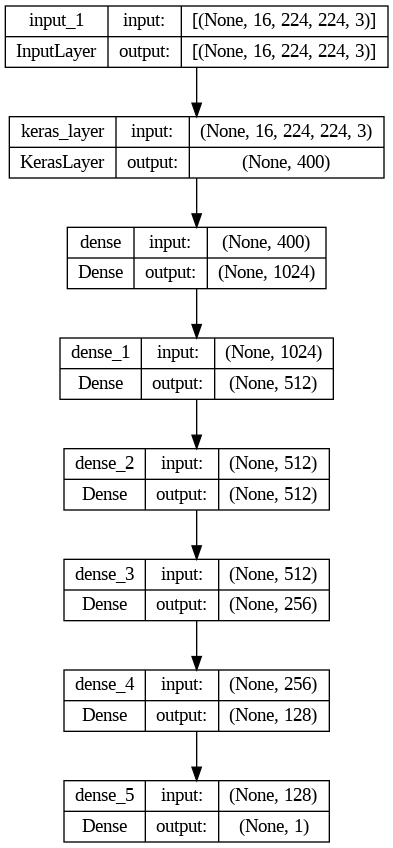

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model_res, to_file='/content/drive/MyDrive/cs231n_project/3D.png', show_shapes=True, show_layer_names=True)

## Res Training

In [ ]:
history_res = model_res.fit(train_dataset, epochs=10, validation_data=val_dataset,class_weight=class_weights)

Epoch 1/10
42/42 [==============================] - 101s 1s/step - loss: 0.8370 - accuracy: 0.6924 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.8417 - val_accuracy: 0.6951 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 95s 1s/step - loss: 0.7651 - accuracy: 0.5591 - precision_4: 0.3304 - recall_4: 0.3442 - val_loss: 0.8451 - val_accuracy: 0.6951 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/10
42/42 [==============================] - 99s 1s/step - loss: 0.8503 - accuracy: 0.6742 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.8450 - val_accuracy: 0.6463 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/10
42/42 [==============================] - 98s 1s/step - loss: 0.7236 - accuracy: 0.4636 - precision_4: 0.2898 - recall_4: 0.4951 - val_loss: 0.8452 - val_accuracy: 0.7195 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 5/10
42/42 [=============

In [ ]:
model_res.save("/content/drive/MyDrive/cs231n_project/3Dmodel_customLoss.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_res.save("baselinemodel.keras")

In [ ]:
history_res_dict = history_res.history
json.dump(history_res_dict, open("training_history_3d_custom", 'w'))

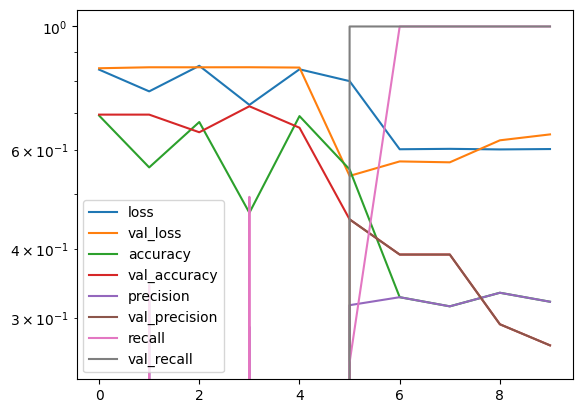

In [ ]:
history_res_df = pd.DataFrame(history_res_dict)

plt.plot(history_res_df['loss'], label='loss')
plt.plot(history_res_df['val_loss'], label='val_loss')
plt.plot(history_res_df['accuracy'], label='accuracy')
plt.plot(history_res_df['val_accuracy'], label='val_accuracy')
plt.plot(history_res_df['precision_4'], label='precision')
plt.plot(history_res_df['val_precision_4'], label='val_precision')
plt.plot(history_res_df['recall_4'], label='recall')
plt.plot(history_res_df['val_recall_4'], label='val_recall')

plt.yscale('log')
plt.legend()
plt.show()


## Res Testing

In [ ]:
model_res = tf.keras.models.load_model("/content/drive/MyDrive/cs231n_project/DeepFake_Baseline_Model.h5")

In [ ]:
model_res.summary()

In [ ]:
data = model_res.evaluate(test_dataset)
print(data)

6/6 [==============================] - 45s 809ms/step - loss: 0.6266 - accuracy: 0.2892 - precision_4: 0.2892 - recall_4: 1.0000
[0.6266398429870605, 0.28915661573410034, 0.28915661573410034, 1.0]


In [ ]:
X_test = test_dataset.map(lambda x, y: x)
y_test = test_dataset.map(lambda x, y: y)
#Baseline Continous Predictions
predicted_test_res = model_res.predict(X_test)
print(predicted_test_res)

In [ ]:
#Changing continuous into binary predictions
predicted_test_res_binary = np.where(predicted_test_res > 0.5, 1.0, 0.0)

In [ ]:
#Getting Res Accuracy and Precision score:

res_test_accuracy = accuracy_score(spatialYList, predicted_test_res_binary)
res_test_precision = precision_score(, predicted_test_res_binary)
res_test_recall = recall_score(yArr, predicted_test_res_binary)

print("Res test Accuracy: ",res_test_accuracy)
print("Res test Precision: ",res_test_precision)
print("Res test Recall: ",res_test_recall)

In [ ]:
print("Total Predicted Labels: ", len(predicted_test_res_binary), "Predicted \"real\" images: ", np.count_nonzero(predicted_test_res_binary))
print("Total Actual Labels: ", len(yArr), "Actual \"real\" images: ", np.count_nonzero(yArr))

In [ ]:
np.savetxt('predicted_labels_face.txt', predicted_test_res)
np.savetxt('correct_labels_face.txt', yArr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## VIDEO LOADER

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

#change if you want a diff number of frames per vid
NUM_FRAMES = 16

def extract_frames(video_path, num_frames=NUM_FRAMES):
    #print(video_path)
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(total_frames)
    frames_step = total_frames // num_frames
    frames = []
    for i in range(num_frames):
        video.set(cv2.CAP_PROP_POS_FRAMES, i*frames_step)
        success, frame = video.read()
        if success:
            frames.append(frame)
    video.release()
    return frames

def preprocess_frame(frame):
    # change frame to a tensor
    frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32)
    # resize to a fifth of the size
    size_tuple = (int(1080*(1/5)), int(1920*(1/5)))
    resized_frame = tf.image.resize(frame_tensor, size_tuple)
    #normalize
    normalized_frame = resized_frame / 255.0
    return normalized_frame

def predict_frames(frames,model):
    predictions = []
    for frame in frames:
        processed_frame = preprocess_frame(frame)
        prediction = model.predict(np.expand_dims(processed_frame, axis=0))
        predictions.append(prediction)
    #print(predictions)
    return predictions

def is_deepfake(predictions, threshold=0.8):
    # Assuming the model outputs a probability of being real
    fake_count = sum(pred > 0.5 for pred in predictions)
    # If the majority of frames are real, the video is considered not a deepfake
    return fake_count >= threshold*len(predictions)  # If not, it's considered a deepfake
#usage below
def is_deepfakeVideo(path,model):
    video_path = path
    #model_path = 'resmodel.h5'

    frames = extract_frames(video_path)
    #print(len(frames))
    predictions = predict_frames(frames, model)
    result = is_deepfake(predictions)
    return result


In [ ]:
with open('/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
labels = data.values()

In [ ]:
def read_json(path, real_only=False):
    with open(path, 'r') as file:
        data = json.load(file)
        if real_only:
            return {mp4_file: 0 for mp4_file, details in data.items() if details['label'] == 'REAL'}
        else:
            return {mp4_file: 1 if details['label'] == 'FAKE' else 1 for mp4_file, details in data.items()}

In [ ]:
path = '/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json'
data = read_json(path)
labels = data.values()

In [ ]:
videoPaths = tf.data.Dataset.list_files("/content/drive/MyDrive/CS131_Proj/test_videos/*.mp4",shuffle = False)
video_paths_array = np.array(list(videoPaths.as_numpy_iterator()), dtype=str)
videoPred = []
count = 1
for path in video_paths_array:
  if count > 30:
    break
  result = is_deepfakeVideo(path,model_res)
  print("DONE: ",count)
  videoPred.append(result)
  count+=1
videoPred_arr = np.array(videoPred)

In [ ]:
yArr = list(labels)[0:30]
yArr = np.array(yArr)
print(videoPred_arr)
print(yArr)

In [ ]:
vid_test_accuracy = accuracy_score(yArr, videoPred_arr)
vid_test_precision = precision_score(yArr, videoPred_arr)
vid_test_recall = recall_score(yArr, videoPred_arr)

print("Vid test Accuracy: ",vid_test_accuracy)
print("Vid test Precision: ",vid_test_precision)
print("Vid test Recall: ",vid_test_recall)